## Example code to reproduce the results of *Developing a Victorious Strategy to the Second Strong Gravitational lensing Data Challenge* by Bom et al.

This notebook is used with a subsample of the ISGLC dataset, using the HJY+VIS(repeated) configuration. The network will be retrained on a given number of images, using the same number for validation and the rest for testing.

In [ ]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
from tensorflow import keras
import cv2
import sklearn.metrics as sk_metrics
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import scipy
from PIL import Image
from tensorflow_addons import optimizers

Include the RADAM optimizer to tf namespace so the model can be loaded

In [ ]:
tf.keras.optimizers.RectifiedAdam = optimizers.RectifiedAdam

Set the parameter:

- n_img: number of images available for training (same number for validation). Evaluation will be done on the rest
- batch_size: batch size to feed model.fit. Must be smaller than n_img
- n_epochs: number of epochs for training

In [ ]:
n_img = 150
batch_size = 50
n_epochs = 10

In [ ]:
def plot_all_bands(img, ax=None):
    img_norm = np.zeros_like(img)
    for i in range(img.shape[-1]):
        norm = ((img[:,:,i:i+1] - img[:,:,i:i+1].min()) / np.ptp(img[:,:,i:i+1]))#*255
        #norm = cv2.normalize(img[:,:,i:i+1], np.zeros_like(img[:,:,i:i+1]), 0, 1.0, cv2.NORM_MINMAX)
        img_norm[:,:,i:i+1] = norm
    if ax == None:
        f, ax = plt.subplots()
    ax.imshow(img_norm, interpolation='nearest', cmap='gray')
    return None

def resize_imgs(imgs, newsize):
    #newsize is a square
    result = np.zeros((imgs.shape[0], newsize, newsize, imgs.shape[-1]))
    for i, img in enumerate(imgs):
        for j in range(imgs.shape[-1]):
            resized = cv2.resize(img[:,:,j], (newsize, newsize), interpolation = cv2.INTER_NEAREST)
            result[i,:,:,j] = resized
    return result
    
    
def combine_bands(imgs, alone=0):
    n_bands = imgs.shape[-1]
    assert alone < n_bands, 'chosen band must be between 0 and {}'.format(n_bands - 1)
    solitary = imgs[:,:,:,alone:alone+1]
    rest_ids = [iid for iid in range(n_bands) if iid != alone]
    #print(rest_ids)
    rest = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2], n_bands-1))
    for j, band in enumerate(rest_ids):
        rest[:,:,:,j] = imgs[:,:,:,band]
        

    return rest, solitary

def fbeta(rec, prec, beta2=0.001):
    return (1+beta2) * (rec*prec) / ((beta2*prec) + rec)

def normalize(arr):
    result = np.zeros_like(arr)
    if arr.shape[-1] > 1:
        for i in range(arr.shape[-1]):
            maxi = np.max(arr[:,:,:,i])
            mini = np.min(arr[:,:,:,i])
            new_arr = (arr[:,:,:,i] - mini) / np.ptp(arr[:,:,:,i])
            result[:,:,:,i] = new_arr
    else:
        maxi = np.max(arr[:,:,:,0])
        mini = np.min(arr[:,:,:,0])
        new_arr = (arr[:,:,:,:1] - mini) / np.ptp(arr[:,:,:,:1])
        result = new_arr
    return result

def create_input_data(data, alone=0, norm=True):
    hjy, vis = combine_bands(data, alone)
    hjy_res = resize_imgs(hjy, 66)
    vis_res = resize_imgs(vis, 200)
    if norm:
        hjy_res = normalize(hjy_res)
        vis_res = normalize(vis_res)
    pad = np.zeros_like(vis_res)
    vis_res = np.concatenate([vis_res, pad, pad], axis=-1)
    return hjy_res, vis_res

In [ ]:
%config Completer.use_jedi=False

Set the directories where the data and model are, load them. One-hot encode the labels since the I SGLC provided them as 0 or 1.

In [ ]:
data_dir = '/tf/bernardo/EscolaCBPF/lensdata'
model_dir = '/tf/bernardo/Challenge2/data'

In [ ]:
imgs = np.load(os.path.join(data_dir, 'imgs_challenge1_git.npy'))
is_lens = np.load(os.path.join(data_dir, 'labels_challenge1_git.npy'))
is_lens = keras.utils.to_categorical(is_lens)

Prepare the data. Since the images are in four bands, we choose one of them to be the equivalent of VIS, while the rest are the equivalent to HJY. We found the best results when $r$ was alone, so we choose its index in `combine_bands` and `create_input_data`, as the images are $ugri$. `combine_bands` only combine the bands this way for plotting, while `create_input_data` also resizes them to the format of the II SGLC (200x200 and 66x66) and normalizes them.

In [ ]:
hjy_plot, vis_plot = combine_bands(imgs, alone=2)
hjy, vis = create_input_data(imgs, alone=2)

Select example lens and no lens for visualization

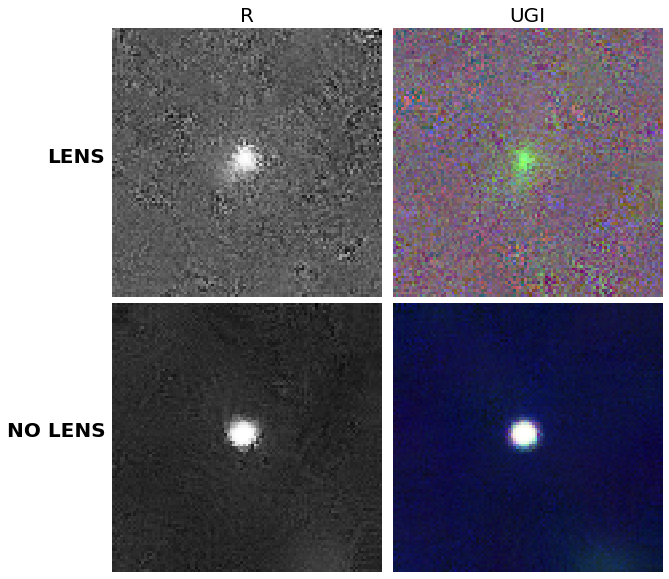

In [ ]:
lens = np.where(is_lens == 1)[0]
nolens = np.where(is_lens == 0)[0]

id_lens = np.random.choice(lens)
id_nolens = np.random.choice(nolens)

f, ax = plt.subplots(2,2,figsize=[10,10], gridspec_kw={'wspace':0.01, 'hspace':0.02})

ax[0,0].imshow(vis_plot[id_lens], interpolation='nearest', cmap='gray')
ax[0,0].set_axis_off()
ax[0,0].set_title('R', fontsize=20)
ax[0,0].annotate('LENS', (10,10), xytext=(-25,50), annotation_clip=False, fontsize=20, weight='bold')

plot_all_bands(hjy_plot[id_lens], ax=ax[0,1])
ax[0,1].set_axis_off()
ax[0,1].set_title('UGI', fontsize=20)

ax[1,0].imshow(vis_plot[id_nolens], interpolation='nearest', cmap='gray')
ax[1,0].set_axis_off()
ax[1,0].annotate('NO LENS', (10,10), xytext=(-40,50), annotation_clip=False, fontsize=20, weight='bold')

plot_all_bands(hjy_plot[id_nolens], ax=ax[1,1])
ax[1,1].set_axis_off()

plt.show()

Load the model. Select random `n_img` from the dataset, split in train/validation/test

In [ ]:
model = keras.models.load_model(os.path.join(model_dir, 'efn2_hjy_vis_newpre_repeated_aug_new_fold5'))

In [ ]:
ids_train = np.random.choice(hjy.shape[0], n_img*2, replace=False)
hjy_train = hjy[ids_train[:n_img]]
vis_train = vis[ids_train[:n_img]]
y_train = is_lens[ids_train[:n_img]]

hjy_val = hjy[ids_train[n_img:]]
vis_val = vis[ids_train[n_img:]]
y_val = is_lens[ids_train[n_img:]]

ids_test = np.array([i for i in range(hjy.shape[0]) if i not in ids_train])
hjy_test = hjy[ids_test]
vis_test = vis[ids_test]
y_test = is_lens[ids_test]

In [ ]:
save_name = '/tf/bernardo/Challenge2/data/test_model'
checkpoint = keras.callbacks.ModelCheckpoint(save_name, monitor='val_loss', save_best_only=True, verbose=1)
history = model.fit([vis_train, hjy_train], y_train, batch_size=batch_size, epochs=n_epochs, 
                    validation_data=([vis_val, hjy_val], y_val), callbacks=[checkpoint])

Epoch 1/10
3/3 [==============================] - 93s 2s/step - loss: 0.7655 - accuracy: 0.6000 - val_loss: 0.7297 - val_accuracy: 0.4867

Epoch 00001: val_loss improved from inf to 0.72965, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets
Epoch 2/10
3/3 [==============================] - 2s 616ms/step - loss: 0.7912 - accuracy: 0.5867 - val_loss: 0.7326 - val_accuracy: 0.5133

Epoch 00002: val_loss did not improve from 0.72965
Epoch 3/10
3/3 [==============================] - 2s 558ms/step - loss: 0.7385 - accuracy: 0.6133 - val_loss: 0.7273 - val_accuracy: 0.5200

Epoch 00003: val_loss improved from 0.72965 to 0.72734, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets
Epoch 4/10
3/3 [==============================] - 2s 612ms/step - loss: 0.6750 - accuracy: 0.6733 - val_loss: 0.7245 - val_accuracy: 0.5067

Epoch 00004: val_loss improved from 0.72734 to 0.72451, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets
Epoch 5/10
3/3 [==============================] - 2s 582ms/step - loss: 0.6204 - accuracy: 0.6733 - val_loss: 0.7235 - val_accuracy: 0.5000

Epoch 00005: val_loss improved from 0.72451 to 0.72349, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets
Epoch 6/10
3/3 [==============================] - 2s 618ms/step - loss: 0.6103 - accuracy: 0.6600 - val_loss: 0.7168 - val_accuracy: 0.5267

Epoch 00006: val_loss improved from 0.72349 to 0.71675, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets
Epoch 7/10
3/3 [==============================] - 2s 564ms/step - loss: 0.6011 - accuracy: 0.6667 - val_loss: 0.7061 - val_accuracy: 0.5533

Epoch 00007: val_loss improved from 0.71675 to 0.70613, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets
Epoch 8/10
3/3 [==============================] - 2s 571ms/step - loss: 0.5321 - accuracy: 0.7533 - val_loss: 0.6935 - val_accuracy: 0.5800

Epoch 00008: val_loss improved from 0.70613 to 0.69347, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets
Epoch 9/10
3/3 [==============================] - 2s 559ms/step - loss: 0.4960 - accuracy: 0.7733 - val_loss: 0.6807 - val_accuracy: 0.5733

Epoch 00009: val_loss improved from 0.69347 to 0.68074, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets
Epoch 10/10
3/3 [==============================] - 2s 562ms/step - loss: 0.4712 - accuracy: 0.7933 - val_loss: 0.6686 - val_accuracy: 0.6000

Epoch 00010: val_loss improved from 0.68074 to 0.66856, saving model to /tf/bernardo/Challenge2/data/test_model


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/bernardo/Challenge2/data/test_model/assets


Load the best model, with the lowest validation loss

In [ ]:
best_model = keras.models.load_model(save_name)

Predict on the test set and get the metrics

In [ ]:
preds = best_model.predict([vis_test, hjy_test])

In [ ]:
fpr, tpr, _ = sk_metrics.roc_curve(y_test[:,1], preds[:,1])
auroc = sk_metrics.roc_auc_score(y_test[:,1], preds[:,1])

precision, recall, _ = sk_metrics.precision_recall_curve(y_test[:,1], preds[:,1])
prauc = sk_metrics.average_precision_score(y_test[:,1], preds[:,1])

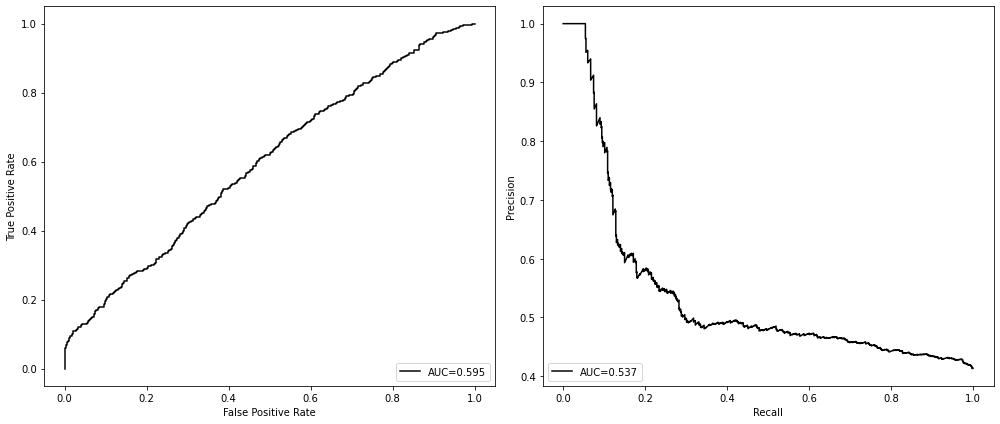

In [ ]:
f, ax = plt.subplots(1,2, figsize=[14,6])

ax[0].plot(fpr, tpr, 'k-', label = 'AUC={:2.3f}'.format(auroc))
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

ax[1].plot(recall, precision, 'k-', label = 'AUC={:2.3f}'.format(prauc))
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(loc='lower left')

plt.tight_layout()
plt.show()